In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black
import ncxt_sxtcnn
import numpy as np

import ncxtamira

<IPython.core.display.Javascript object>

In [2]:
import logging

logger = logging.getLogger("ncxt_sxtcnn.sxtcnn").setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [5]:
from ncxt_sxtcnn.hxdatabase import Database
from ncxt_sxtcnn.sxtcnn.loaders import AmiraLoaderx100
from ncxt_sxtcnn.sxtcnn.loaders import AmiraLoaderClahe
from ncxt_sxtcnn.sxtcnn.models import UNet3D
from ncxt_sxtcnn.sxtcnn.processors import RandomBlockProcessor
from ncxt_sxtcnn.sxtcnn.criteria import CrossEntropyLoss_DiceLoss

<IPython.core.display.Javascript object>

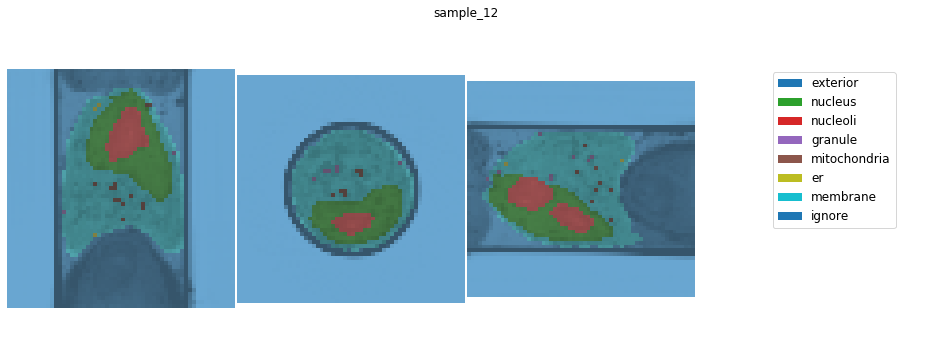

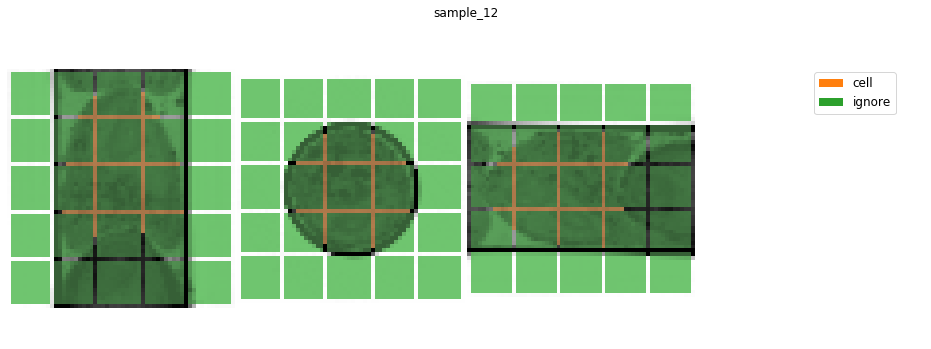

<IPython.core.display.Javascript object>

In [4]:


proj = ncxtamira.AmiraProject("./mockdata/pi1/sample_12.hx")
proj.preview()

labels = np.copy(proj.labels)
labels[labels == proj.key["ignore"]] = 0
labels[labels > 0] = 1
key = {"void": 0, "cell": 1, "ignore": 2}

sparse_labels = np.ones(proj.lac.shape, dtype="uint8") * key["ignore"]
slices = 4
nx, ny, nz = proj.lac.shape
slices0 = np.linspace(0, nx - 1, slices + 2).astype(int)
slices1 = np.linspace(0, ny - 1, slices + 2).astype(int)
slices2 = np.linspace(0, nz - 1, slices + 2).astype(int)
sparse_labels[slices0, :, :] = labels[slices0, :, :]
sparse_labels[:, slices1, :] = labels[:, slices1, :]
sparse_labels[:, :, slices2] = labels[:, :, slices2]

out = ncxtamira.AmiraTemplate(proj.lac, sparse_labels, key, name="sample_12")
out.preview()

out.export("./interpolate/")

### Setup Database

In [5]:


db = Database("interpolate/")
membrane = ["membrane"]
hxfiles = db.filelist(membrane)
db.dataframe_sel(membrane)

interpolate/


C:\Users\axela\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,project,sample,void,membrane,ignore
0,interpolate,sample_12,0,1,2


<IPython.core.display.Javascript object>

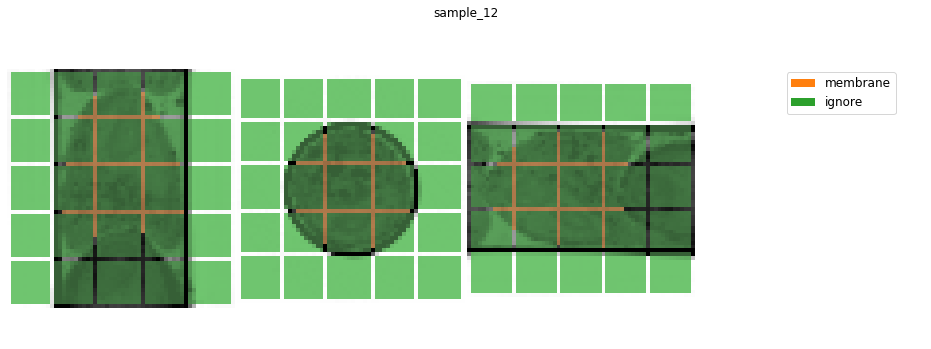

<IPython.core.display.Javascript object>

In [6]:
import ncxtamira

proj = ncxtamira.CellProject(hxfiles[0])
proj.preview()

In [16]:
from ncxt_sxtcnn import SXTCNN

files = db.filelist(membrane)
features = [["*"]]
working_directory = "C:/Users/axela/Documents/2020/example_interp/"

loader_args = {"files": files, "features": features}
processor_args = {"block_shape": (32, 32, 32), "binning": 2, "pad": 8}
model_args = {
    "num_classes": len(features) + 1,
    "depth": 3,
    "start_filts": 32,
    "dropout": None,
    "instancenorm": True,
}
crit_args = {"ignore_index": len(features) + 1}

loader = AmiraLoaderx100(**loader_args)
print(loader.files)
processor = RandomBlockProcessor(**processor_args)
model = UNet3D(**model_args)
criterion = CrossEntropyLoss_DiceLoss(**crit_args)
settings = {"maximum_iterations": 20}

interpolator = SXTCNN(
    loader,
    processor,
    model,
    criterion,
    working_directory=working_directory,
    conf=settings,
)
print(interpolator.settings.ignore)
print(interpolator.criterion.ignore_index)

['interpolate\\sample_12.hx']
2
2


<IPython.core.display.Javascript object>

INFO     [sxtcnn.py:427] Initializing data: C:\Users\axela\Documents\2020\example_interp\data32084
INFO     [sxtcnn.py:428] Training: [0]
INFO     [sxtcnn.py:429] Vsalidation: [0]


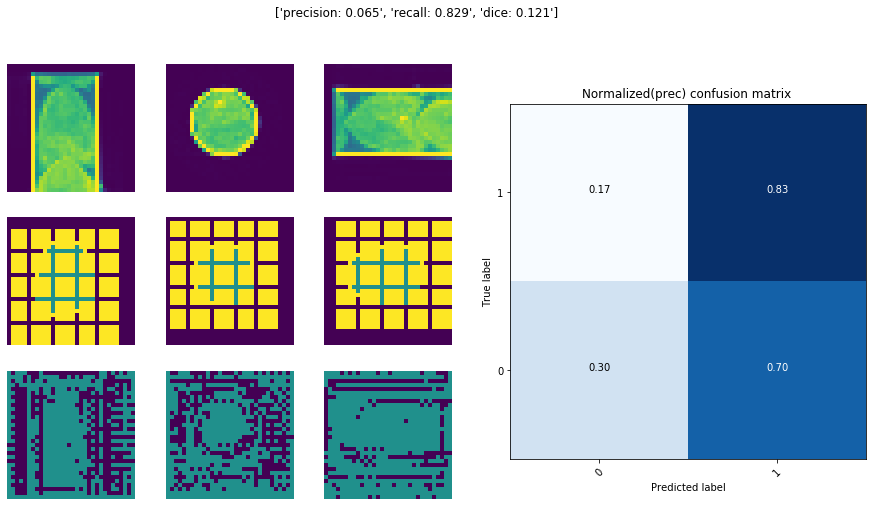

<IPython.core.display.Javascript object>

In [17]:
interpolator.init_kfold(0, 0)
interpolator.evaluate_training_data()


INFO     [sxtcnn.py:403] Setting device to cuda:0


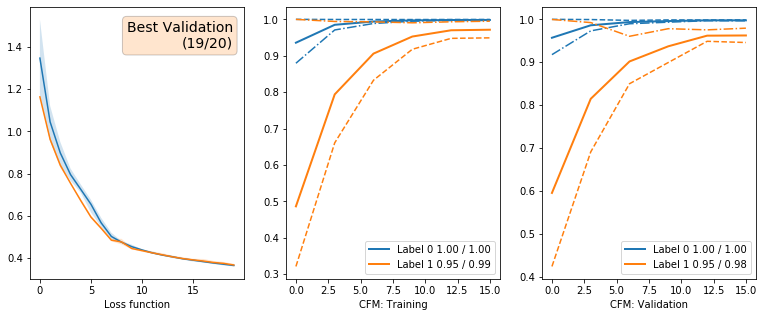

<IPython.core.display.Javascript object>

In [18]:
interpolator.run()
interpolator.logger.plot()

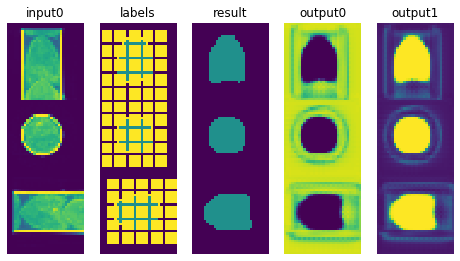

<IPython.core.display.Javascript object>

In [19]:
interpolator.show_training_data()


In [15]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

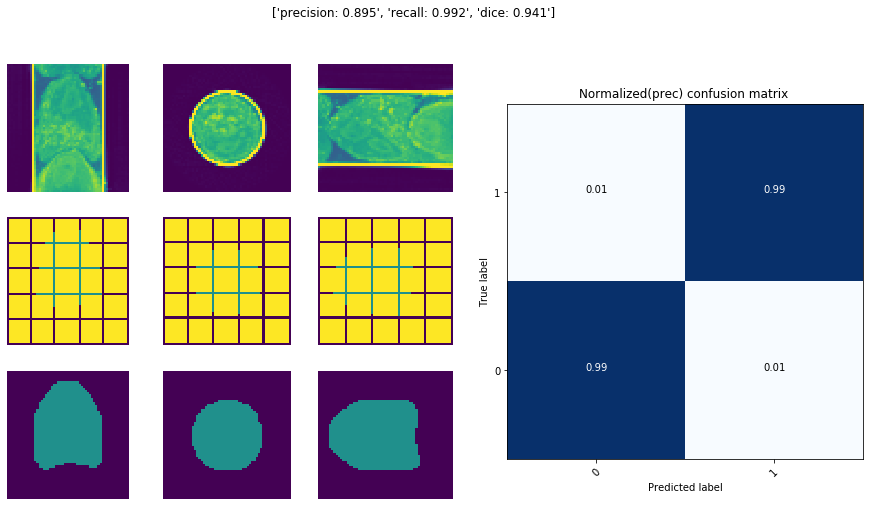

<IPython.core.display.Javascript object>

In [24]:
_ = interpolator.evaluate_sample(0, plot=True)
plt.savefig("interpolate")

### transfer

mockdata/


C:\Users\axela\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


['mockdata\\pi2\\sample_9.hx']


INFO     [sxtcnn.py:420] Data folder C:\Users\axela\Documents\2020\example_interp\data16688\train already exists
INFO     [sxtcnn.py:403] Setting device to cuda:0


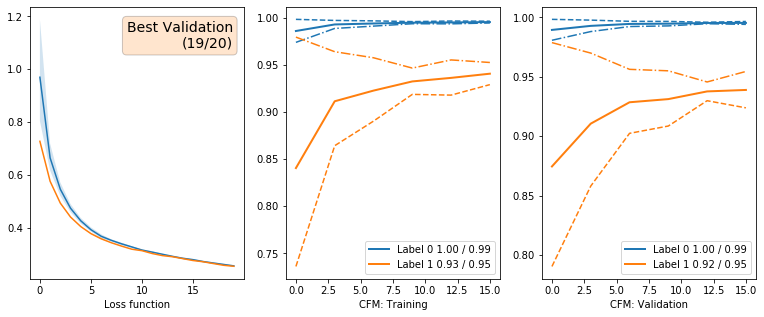

<IPython.core.display.Javascript object>

In [6]:
from ncxt_sxtcnn import SXTCNN

files = Database("mockdata/").filelist(["membrane"])
files.pop(0)

features = [["*"]]
working_directory = "C:/Users/axela/Documents/2020/example_interp/"

loader_args = {"files": files, "features": features}
processor_args = {"block_shape": (32, 32, 32), "binning": 2, "pad": 8}
model_args = {
    "num_classes": len(features) + 1,
    "depth": 3,
    "start_filts": 32,
    "dropout": None,
    "instancenorm": True,
}
crit_args = {"ignore_index": len(features) + 1}

loader = AmiraLoaderx100(**loader_args)
print(loader.files)
processor = RandomBlockProcessor(**processor_args)
model = UNet3D(**model_args)
criterion = CrossEntropyLoss_DiceLoss(**crit_args)
settings = {"maximum_iterations": 20}

base = SXTCNN(
    loader,
    processor,
    model,
    criterion,
    working_directory=working_directory,
    conf=settings,
)
base.init_kfold(0, 0)
base.run()
base.logger.plot()

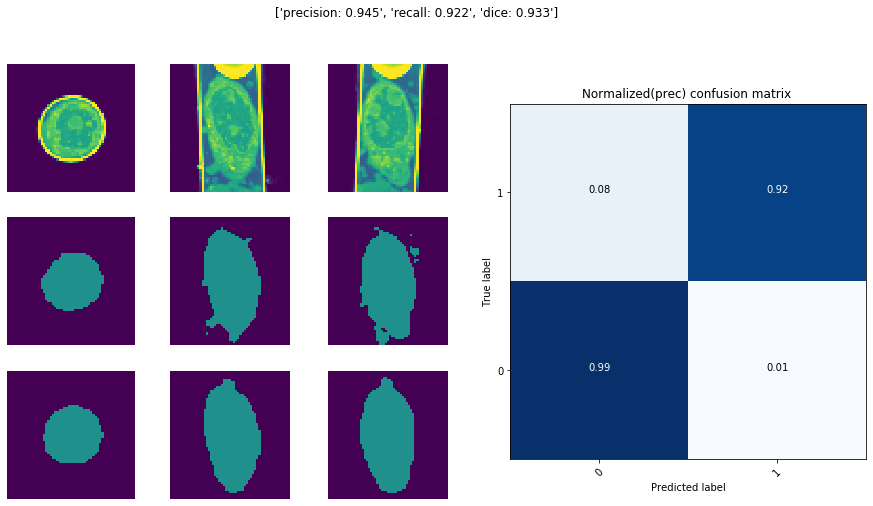

<IPython.core.display.Javascript object>

In [7]:
_ = base.evaluate_sample(0, plot=True)

In [26]:
from ncxt_sxtcnn import SXTCNN

db = Database("interpolate/")
membrane = ["membrane"]

files = db.filelist(membrane)
features = [["*"]]
working_directory = "C:/Users/axela/Documents/2020/example_interp/"

loader_args = {"files": files, "features": features}
processor_args = {"block_shape": (32, 32, 32), "binning": 2, "pad": 8}
model_args = {
    "num_classes": len(features) + 1,
    "depth": 3,
    "start_filts": 32,
    "dropout": None,
    "instancenorm": True,
}
crit_args = {"ignore_index": len(features) + 1}

loader = AmiraLoaderx100(**loader_args)
print(loader.files)
processor = RandomBlockProcessor(**processor_args)
model = UNet3D(**model_args)
criterion = CrossEntropyLoss_DiceLoss(**crit_args)
settings = {"maximum_iterations": 100}

interpolator = SXTCNN(
    loader,
    processor,
    model,
    criterion,
    working_directory=working_directory,
    conf=settings,
)
interpolator.init_kfold(0, 0)

interpolate/
['interpolate\\sample_12.hx']


INFO     [sxtcnn.py:420] Data folder C:\Users\axela\Documents\2020\example_interp\data32084\train already exists


<IPython.core.display.Javascript object>

In [27]:
base_params = base.model.named_parameters()
params_dict = dict(interpolator.model.named_parameters())
for name_base, param_base in base_params:
    if name_base in params_dict:
        if param_base.shape == params_dict[name_base].shape:
            params_dict[name_base].data.copy_(param_base.data)
            print(f"Copied {name_base}")

Copied conv_final.weight
Copied conv_final.bias
Copied down_convs.0.block1.conv.weight
Copied down_convs.0.block1.conv.bias
Copied down_convs.0.block2.conv.weight
Copied down_convs.0.block2.conv.bias
Copied down_convs.1.block1.conv.weight
Copied down_convs.1.block1.conv.bias
Copied down_convs.1.block2.conv.weight
Copied down_convs.1.block2.conv.bias
Copied down_convs.2.block1.conv.weight
Copied down_convs.2.block1.conv.bias
Copied down_convs.2.block2.conv.weight
Copied down_convs.2.block2.conv.bias
Copied up_convs.0.upconv.weight
Copied up_convs.0.upconv.bias
Copied up_convs.0.block1.conv.weight
Copied up_convs.0.block1.conv.bias
Copied up_convs.0.block2.conv.weight
Copied up_convs.0.block2.conv.bias
Copied up_convs.1.upconv.weight
Copied up_convs.1.upconv.bias
Copied up_convs.1.block1.conv.weight
Copied up_convs.1.block1.conv.bias
Copied up_convs.1.block2.conv.weight
Copied up_convs.1.block2.conv.bias


<IPython.core.display.Javascript object>

INFO     [sxtcnn.py:403] Setting device to cuda:0


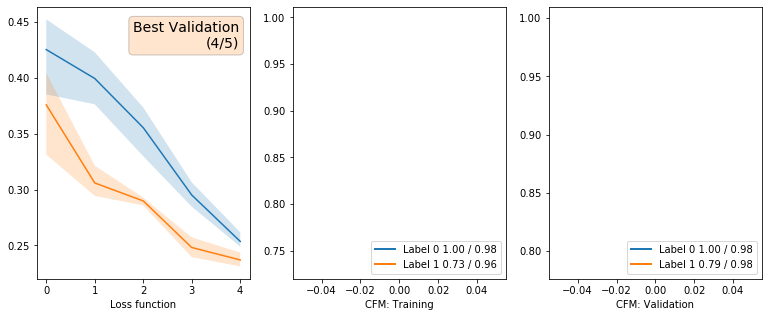

<IPython.core.display.Javascript object>

In [28]:
interpolator.run()
interpolator.logger.plot()

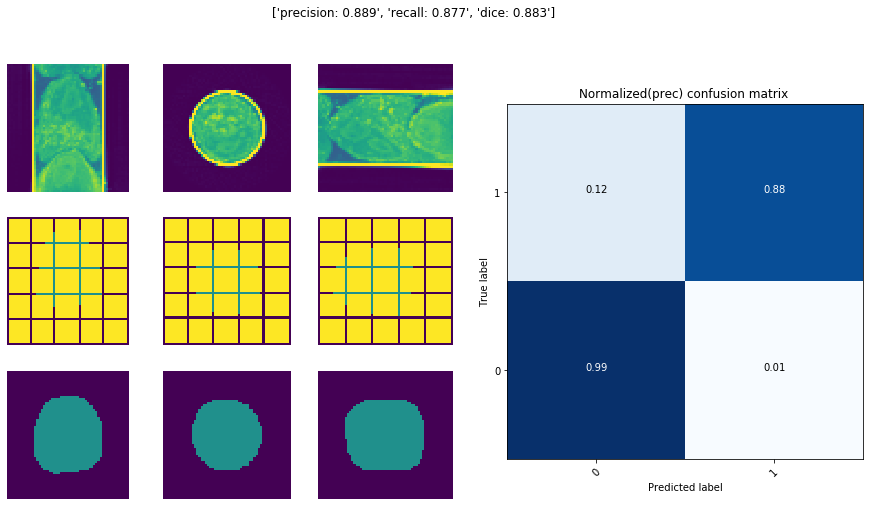

<IPython.core.display.Javascript object>

In [29]:
_ = interpolator.evaluate_sample(0, plot=True)
plt.savefig("interpolate_transfer5")

### check loss

In [ ]:
db = Database("mockdata//")
membrane = ["membrane"]
hxfiles = db.filelist(membrane)
db.dataframe_sel(membrane)

In [ ]:
check_loader = AmiraLoaderx100(hxfiles, ["*"])
check_proc = RandomBlockProcessor(**processor_args)
check_proc.setloader(check_loader)
dx, dy = check_proc[0]
import ncxtutils

print(dx[0].shape)
ncxtutils.volshow(dx[0][0])
ncxtutils.volshow(dy[0])

In [ ]:
from ncxt_sxtcnn.utils.ndarray import labels2prob

y_prob = labels2prob(dy[0] == 1)
ncxtutils.volshow(y_prob[0])
ncxtutils.volshow(y_prob[1])

In [ ]:
import torch
from ncxt_sxtcnn.sxtcnn.criteria import CrossEntropyLoss
from ncxt_sxtcnn.sxtcnn.criteria import CrossEntropyLoss_DiceLoss
from ncxt_sxtcnn.sxtcnn.criteria import DiceLoss

x = labels2prob(dy[0] == 1) * 10
y = dy[0]

y0 = np.copy(dy[0])
y0[:16, :, :] = 2

y1 = np.copy(dy[0]) * 0
y1[:16, :, :] = 2

y_ignore_all = np.ones(y.shape) * 2


def check_loss(x, y):
    torch_x = torch.from_numpy(x.astype("float32"))
    torch_y = torch.from_numpy(y.astype("float32")).long()

    torch_x = torch_x.view(1, *torch_x.shape)
    torch_y = torch_y.view(1, *torch_y.shape)

    print(criterion(torch_x, torch_y))


print("CrossEntropyLoss")
criterion = CrossEntropyLoss(ignore_index=2)
check_loss(x, y)
check_loss(x, y0)
check_loss(x, y1)

print("DiceLoss")
criterion = DiceLoss(ignore_index=2)
check_loss(x, y)
check_loss(x, y0)
check_loss(x, y1)

print("CrossEntropyLoss_DiceLoss")
criterion = CrossEntropyLoss_DiceLoss(ignore_index=2)
check_loss(x, y)
check_loss(x, y0)
check_loss(x, y1)